**1. IMPORTER LES LIBRAIRIES**

In [10]:
#!pip install tensorflow==2.12.0 & keras==2.12.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Deep Learning
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from tensorflow.python.keras import regularizers

# Performances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Performances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Enregistrer le modèle
from sklearn import model_selection
import joblib

import warnings
warnings.filterwarnings('ignore')

**2. IMPORTER LE FICHIER**

In [11]:
df = pd.read_csv("2. Pre-processing & Feature engineering_1.csv")
df = df[['commentaires', 'notes']]
# Remplace les notes 1,2,3,4,5 par 0,1,2,3,4
df['notes'] = df['notes'].replace((1, 2, 3, 4, 5), (0, 0, 0, 1, 1))

df.head()

,commentaires,notes
0,commandee simple et rapide commande simple et ...,1
1,rapide et simple tres bon service,1
2,Honorable bon suivi !,1
3,Cdiscount cautionne l'escroquerie en ce… Cdisc...,0
4,"Simple Simple, rapide, prix raisonnables et €c...",1


**3. PRE-PROCESSING & FEATURE ENGINEERING_2**

In [12]:
#############################
### Nettoyage des données ###
#############################
def clean_str(commentaire):
    commentaire = str(commentaire)
    commentaire = re.sub(r'([^\s\w]|_)+', '', commentaire)
    return commentaire.strip().lower()

df['text'] = df['commentaires'].apply(clean_str)

##########################
### Ré-échantillonnage ###
##########################
# df['notes'].value_counts()
# >>> 0:16886, 1:56960
df_0 = df[df['notes'] == 0].sample(frac=1)
df_1 = df[df['notes'] == 1].sample(frac=1)

sample_size = len(df[df['notes'] == 0]) # Nombre d'échantillons minimum
data = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

####################
### Tokenization ###
####################
sequence_length = 100
max_features = 40000

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['commentaires'].values)
X = tokenizer.texts_to_sequences(data['commentaires'].values)

###############
### PADDING ###
###############
X = pad_sequences(X, sequence_length)

##############
### TARGET ###
##############
y = data['notes'].values

**4. TRAIN_TEST_SPLIT**

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification
print("X_train =", X_train.shape)
print("X_test =", X_test.shape)
print("y_train =", y_train.shape)
print("y_test =", y_test.shape)

X_train = (27017, 100)
X_test = (6755, 100)
y_train = (27017,)
y_test = (6755,)


**5. MODELISATION 1 : CNN aléatoire**

In [14]:
embedding_dim = 300
num_filters = 100
batch_size = 128
epochs = 20

In [15]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',					
                                         min_delta = 0.01 ,				
                                         patience = 3,					
                                         factor = 0.1, 				
                                         cooldown = 4,				
                                         verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               patience = 5,
                               verbose = 1,
                               mode='min',
                               restore_best_weights = True)

*1) Modélisation*

In [16]:
########################
### Architecture CNN ###
########################
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=1, activation='sigmoid')(dropout)

###################
### Compilation ###
###################
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

##############################
### Entraînement du modèle ###
##############################
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_split=0.2,
                    shuffle=True)
                    #callbacks = [reduce_learning_rate, early_stopping])

Epoch 1/20
169/169 [==============================] - 31s 179ms/step - loss: 486.8547 - accuracy: 0.6627 - val_loss: 11.8788 - val_accuracy: 0.6952
Epoch 2/20
169/169 [==============================] - 29s 174ms/step - loss: 2.8793 - accuracy: 0.6489 - val_loss: 0.7563 - val_accuracy: 0.6020
Epoch 3/20
169/169 [==============================] - 31s 182ms/step - loss: 0.6914 - accuracy: 0.6539 - val_loss: 0.6646 - val_accuracy: 0.6776
Epoch 4/20
169/169 [==============================] - 28s 166ms/step - loss: 0.6518 - accuracy: 0.6778 - val_loss: 0.6445 - val_accuracy: 0.6764
Epoch 5/20
169/169 [==============================] - 27s 162ms/step - loss: 0.6245 - accuracy: 0.7176 - val_loss: 0.6069 - val_accuracy: 0.7302
Epoch 6/20
169/169 [==============================] - 29s 172ms/step - loss: 0.5856 - accuracy: 0.7817 - val_loss: 0.5785 - val_accuracy: 0.8042
Epoch 7/20
169/169 [==============================] - 30s 175ms/step - loss: 0.5563 - accuracy: 0.8154 - val_loss: 0.5936 - val

*2) Performances du modèle*

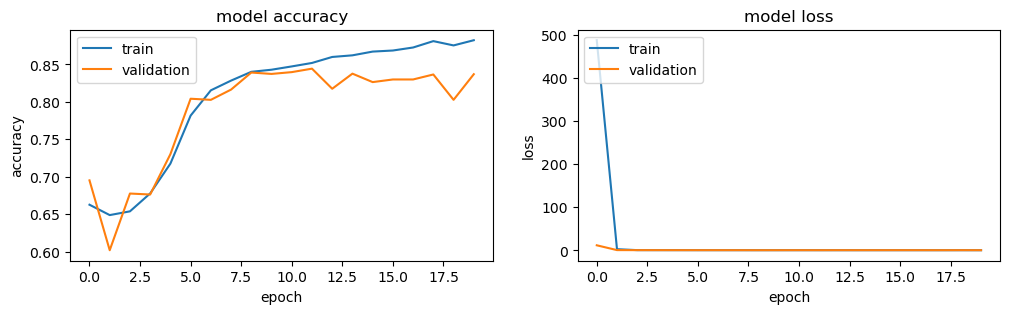

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(X_test)
accuracy_score(y_test, list(map(lambda v: v > 0.5, y_pred)))

print(classification_report(y_test, list(map(lambda v: v > 0.5, y_pred))))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, list(map(lambda v: v > 0.5, y_pred)))

212/212 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3402
           1       0.82      0.86      0.84      3353

    accuracy                           0.84      6755
   macro avg       0.84      0.84      0.84      6755
weighted avg       0.84      0.84      0.84      6755



array([[2784,  618],
       [ 465, 2888]], dtype=int64)

**6. ENREGISTREMENT DU MODELE**

In [19]:
joblib.dump(model, '7.b) Deep_Learning_2.pkl')

['7.b) Deep_Learning_2.pkl']